In [547]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import chi2_contingency
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as pc
import statsmodels.api as sm

there will be two "main files". one jupyter notebook for development and another python file containing the same code, so that it can be imported into the unit testing and continuous integration.

Text(0.5, 1.0, 'Variable Relationships')

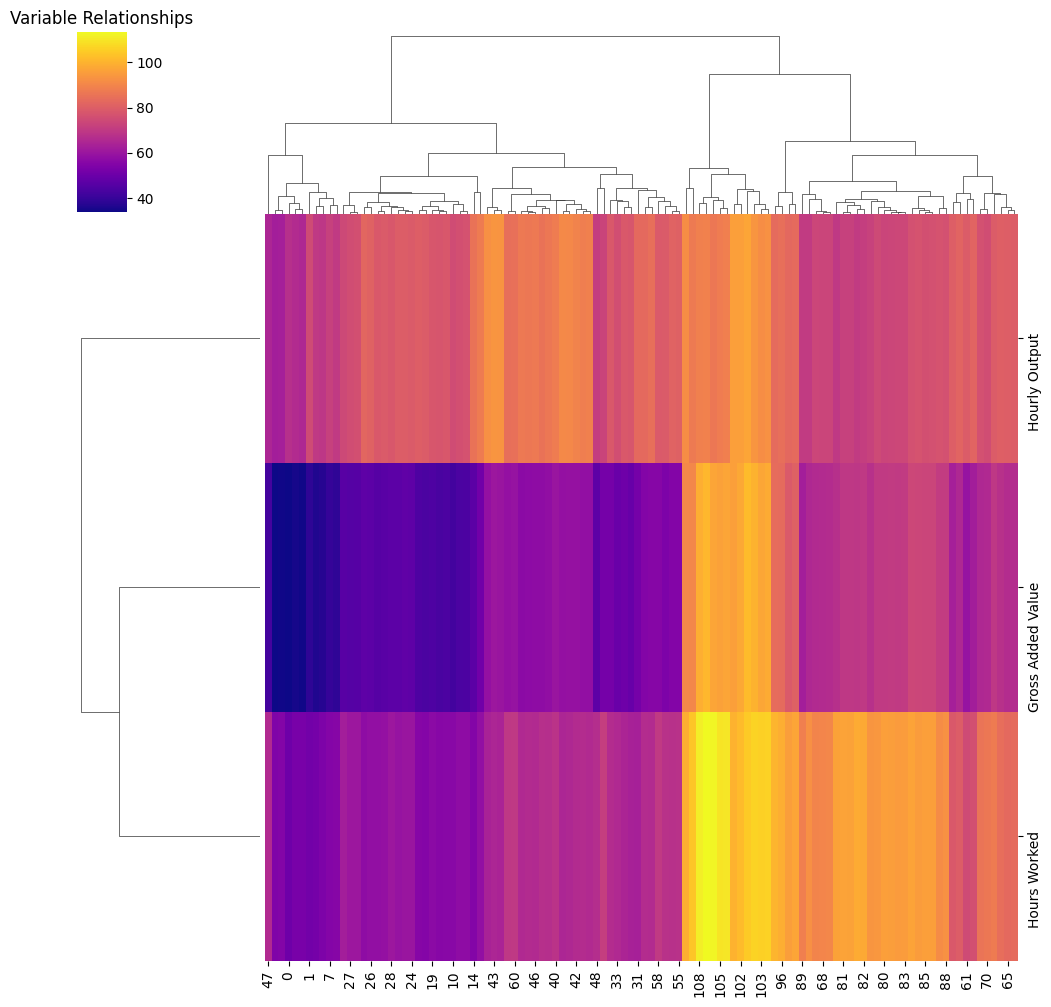

In [548]:
mc_final = pd.read_csv('../datasets/management_consulting_final.csv')

#clustered heatmap to see which variables behave similarly and which behave differently.
cols = ['Gross Added Value', 'Hours Worked', 'Hourly Output']
mc_subset = mc_final[cols]
sns.clustermap(mc_subset.T, cmap='plasma')
plt.title("Variable Relationships")

observations:
gva and hours worked are clustered,
hourly output is more seperated

not a very clear graph so will move on from this, but know it is known that hours worked and gross added value move relatively together, so we will further this via correlation analysis.


<Axes: >

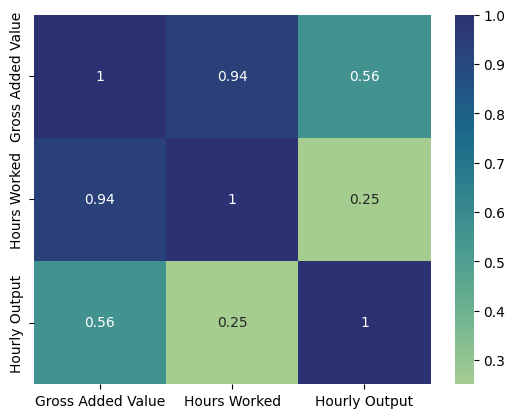

In [549]:
#zooming in with a correlation heatmap
sns.heatmap(mc_subset.corr(), annot=True, cmap='crest')

In [550]:
#looking at the relationship between gva vs hours worked
x, y = mc_subset['Hours Worked'], mc_subset['Gross Added Value']
result = stats.linregress(x, y)

print(f" slope = {result.slope}, intercept = {result.intercept}")
print(f" Pearson correlation = {result.rvalue}, and p-value = {result.pvalue}")
print(f" std-err in slope = {result.stderr}, and in intercept = {result.intercept_stderr}")

 slope = 0.8866224086853892, intercept = -6.520805650405023
 Pearson correlation = 0.9380608019297002, and p-value = 1.5683234483771696e-51
 std-err in slope = 0.031511010111170565, and in intercept = 2.47642744530587


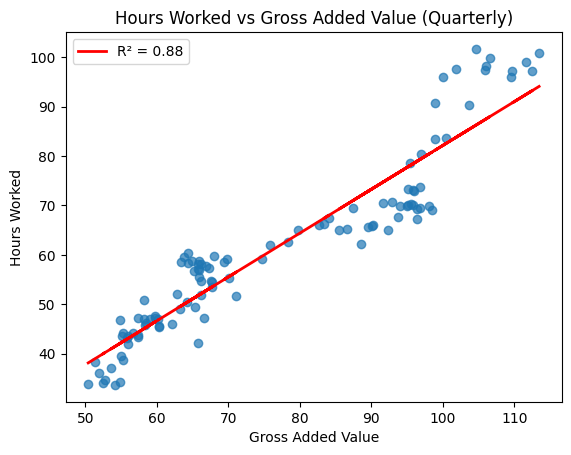

In [551]:
#linear relationship is preferred, so lets look at that.
r2 = result.rvalue ** 2

# Plot
plt.scatter(x, y, alpha=0.7)

plt.plot(x, result.intercept + result.slope * x, color='red', linewidth=2, label=f'R² = {r2:.2f}')

plt.xlabel('Gross Added Value')
plt.ylabel('Hours Worked')

plt.legend(loc='upper left')
plt.title("Hours Worked vs Gross Added Value (Quarterly)")
plt.show()

In [552]:
df = mc_subset
x = df['Gross Added Value']
y = df['Hours Worked'] #incorporating confidence interval and color scheme with plotly and stats api

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
predictions = model.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05) 

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(
        size=12,
        color=x,
        colorscale=pc.sequential.Plasma,
        line=dict(width=0.5, color='white'),
        opacity=0.8,
        showscale=True,
        #colorbar=dict(title='Gross Added Value')
    ),
    hovertemplate='<b>GVA:</b> %{x:.1f}<br><b>Hours:</b> %{y:.1f}<extra></extra>',
    name='Data Points'
))

fig.add_trace(go.Scatter(
    x=x,
    y=pred_summary['mean'],
    mode='lines',
    line=dict(color='red', width=2),
    name='OLS Fit'
))

fig.add_trace(go.Scatter(
    x=np.concatenate([x, x[::-1]]),
    y=np.concatenate([pred_summary['mean_ci_upper'], pred_summary['mean_ci_lower'][::-1]]),
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='95% CI'
))

r2 = model.rsquared
fig.add_annotation(
    x=0.05, y=0.95,
    xref="paper", yref="paper",
    text=f"<b>R² = {r2:.2f}</b>",
    showarrow=False,
    bgcolor="rgba(219, 64, 82, 0.8)",
    font=dict(color="white", size=12),
    bordercolor="white",
    borderwidth=1,
    borderpad=4
)

fig.update_layout(
    title='Hours Worked vs Gross Added Value (Quarterly)',
    xaxis_title='Gross Added Value',
    yaxis_title='Hours Worked',
    height=600,
    width=800,
    plot_bgcolor='rgba(240,240,250,0.5)',
    font=dict(size=12)
)
fig.update_layout(showlegend=False)
fig.show()


In [553]:
#using bic to check if hours worked is just noise for the gva
n = len(y)

rss_null = np.sum((y - np.mean(y))**2)
bic_null = n * np.log(rss_null / n) + 1 * np.log(n)

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
rss_lin = np.sum((y - y_pred)**2)
bic_lin = n * np.log(rss_lin / n) + 2 * np.log(n)

print(f"BIC null: {bic_null:.2f}, BIC linear: {bic_lin:.2f}, ΔBIC: {bic_lin - bic_null:.2f}")


BIC null: 646.20, BIC linear: 417.71, ΔBIC: -228.49


conclusion: hours worked effect the gross value added. This is an obvious takeway and nothing surprising. The more you work, the more overall value you're adding to the company. but, now we wish to look at why working more hours

In [554]:
x1, y1 = mc_subset['Hours Worked'], mc_subset['Hourly Output']
result = stats.linregress(x1, y1)

print(f" slope = {result.slope}, intercept = {result.intercept}")
print(f" Pearson correlation = {result.rvalue}, and p-value = {result.pvalue}")
print(f" std-err in slope = {result.stderr}, and in intercept = {result.intercept_stderr}")

#also checking spearman correlation
stats.spearmanr(x1, y1)

 slope = 0.1047032060252023, intercept = 71.66037839708243
 Pearson correlation = 0.25045458536688503, and p-value = 0.00831551661971523
 std-err in slope = 0.038945030887295604, and in intercept = 3.0606617498876796


SignificanceResult(statistic=np.float64(0.2707075716250028), pvalue=np.float64(0.004231299569438237))

weak correlation here and a valid p value of under 0.05 which illustrates credibility of our hypothesis. zooming in...

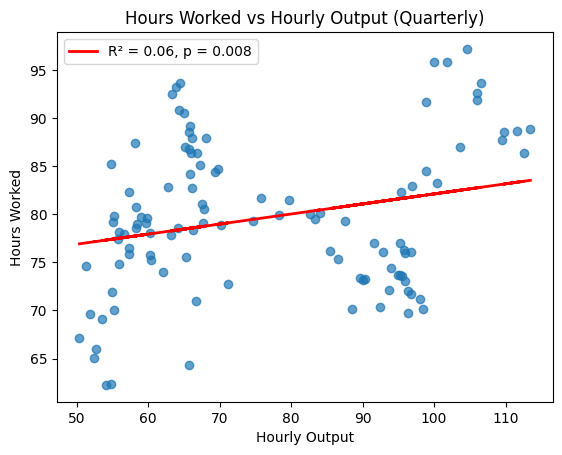

In [555]:
#checking out the lack of correlation in hourly output vs hours worked.
r2 = result.rvalue ** 2

# Plot
plt.scatter(x1, y1, alpha=0.7)

plt.plot(x1, result.intercept + result.slope * x1, color='red', linewidth=2, label=f'R² = {r2:.2f}, p = {result.pvalue:.3f}')

plt.xlabel('Hourly Output')
plt.ylabel('Hours Worked')

plt.legend(loc='upper left')
plt.title("Hours Worked vs Hourly Output (Quarterly)")
plt.show()


In [556]:
r2 = result.rvalue ** 2

fig = px.scatter(
    df,
    x='Hourly Output',
    y='Hours Worked',
    color='Hourly Output',              
    color_continuous_scale=pc.sequential.Viridis,
    trendline='ols',
    title='Hours Worked vs Hourly Output (Quarterly)',
    labels={
        'Hourly Output': 'Hourly Output',
        'Hours Worked': 'Hours Worked'
    },
    hover_data={
        'Hourly Output': ':.1f',
        'Hours Worked': ':.1f'
    }
)

fig.update_traces(marker=dict(size=12, line=dict(width=0.5, color='white'), opacity=0.8))

fig.add_annotation(
    x=0.05, y=0.95,
    xref="paper", yref="paper",
    text=f"<b>R² = {r2:.2f}</b>",
    showarrow=False,
    bgcolor="rgba(219, 64, 82, 0.8)",
    font=dict(color="white", size=12),
    bordercolor="white",
    borderwidth=1,
    borderpad=4
)

fig.update_layout(
    height=600,
    width=800,
    plot_bgcolor='rgba(240, 240, 250, 0.5)',
    font=dict(size=12)
)

fig.show()


Working more hours initially might increase output slightly.  
But beyond 60ish hours/week, productivity per hour collapses.  
The highest performers (95-112 output) work a RANGE of hours, not necessarily the longest.  

**we're now going to validate this regression via a chi square test with the original data.**

so now we've seen the relationship. let's consider the actual values.   
we will pull in a dataset with the same values, but not index aggregated. we will put them into respective bins and then carry out a chi squared test to strengthen our hypothesis.

In [560]:
#will carry out a further chi squared test to validate

def extract_quarter_and_values(sheet_name, value_column_name): #getting the original values.
    raw = pd.read_excel("../datasets/master_productivityds.xlsx", sheet_name=sheet_name, header=None)
    header_row = raw.index[raw[0] == 'Quarter'][0]
    df = pd.read_excel("../datasets/master_productivityds.xlsx", sheet_name=sheet_name,skiprows=header_row)

    df = df[['Quarter', 'Activities of head offices; management consultancy activities']].copy()
    df.rename(columns={'Activities of head offices; management consultancy activities': value_column_name}, inplace=True)
    df = df[df['Quarter'].str.match(r'\d{4} Q[1-4]')]

    return df.reset_index(drop=True)

raw_hoursworked_table26 = extract_quarter_and_values("Table_26", 'Raw Hours Worked')
raw_hourly_output_table28 = extract_quarter_and_values("Table_28", 'Raw Hourly Output')
raw_mergeddf = pd.merge(raw_hoursworked_table26, raw_hourly_output_table28, on='Quarter', how='inner')

df = raw_mergeddf.copy()

df['Hours_bin'] = pd.qcut(df['Raw Hours Worked'], q=3, labels=['Low', 'Medium', 'High'])
df['Output_bin'] = pd.qcut(df['Raw Hourly Output'], q=3, labels=['Low', 'Medium', 'High'])

contingency = pd.crosstab(df['Hours_bin'], df['Output_bin'])

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"χ² = {chi2:.2f}")
print(f"dof = {dof}")
print(f"p-value = {p:.4g}")

χ² = 96.32
dof = 4
p-value = 5.983e-20


We derive from this chi square test that people who work different amounts of hours tend to fall into different output groups more often than pure chance would allow. There isn't one particular bin you fall into if you work a certain number of hours. While hours worked and hourly output are statistically associated, hours worked explains very little of the variation in hourly productivity.

## Final Conclusion: Working more hours does not meaningfully improve productivity per hour. Therefore, consultants working extended hours in a day does not magically equate to increased revenue for the company. Rather, these hours can be spread out naturally across multiple days, weeks, etc.